# Exploration 8

## Human Segmentation
### 인물 모드 문제점 찾기

### Table of Contents
1. [데이터 준비]()
2. [DeepLab 모델 준비]()
3. [Segmentation 결과확인]()
4. [Blur 이미지]()
5. [원본 이미지와 Blur 이미지 합성]()
6. [배경변경]()
7. [문제점]()

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline
import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import networks
from utils import download_model_if_doesnt_exist
import cv2
import tarfile
import urllib
import tensorflow as tf

## 1. 데이터 준비

- 먼저 효과를 적용할 사진들을 출력해보자.

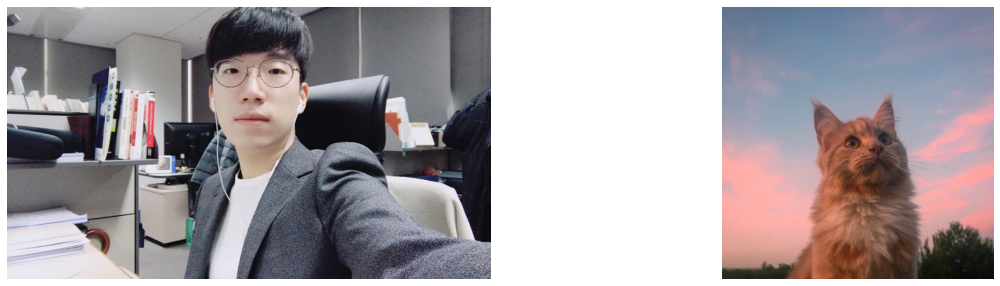

In [2]:
img_path = os.getenv('HOME')+'/aiffel/Exploration/AA/monodepth2-master/data/images/' 

img_human = cv2.imread(img_path+'E-14-3.png')
img_cat = cv2.imread(img_path+'cat1.jpg')

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(20, 5)
for ax in axes:
    ax.axis('off')

axes[0].imshow(cv2.cvtColor(img_human, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))
plt.show()

## 2. DeepLab 모델 준비

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

사전학습된 가중치를 불러온다.

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = 'data/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: data/models
model loaded successfully!


준비한 이미지를 네트워크에 입력해보자

In [5]:
img_human_re, seg_map_human = MODEL.run(img_human)
img_cat_re, seg_map_cat = MODEL.run(img_cat)
print(img_human.shape, img_human_re.shape, seg_map_human.max())
print(img_cat.shape, img_cat_re.shape, seg_map_cat.max())

(450, 800, 3) (288, 513, 3) 20
(604, 604, 3) (513, 513, 3) 8


구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 종류는 아래와 같다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

## 3. Segmentation 결과 확인

- 각 이미지에서 '사람'과 '고양이'라벨만 추출

In [7]:
def get_segmetation_image(image, seg_map, label):
    img_show = image.copy()
    seg_map = np.where(seg_map == label, label, 0)
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    return img_mask, img_show

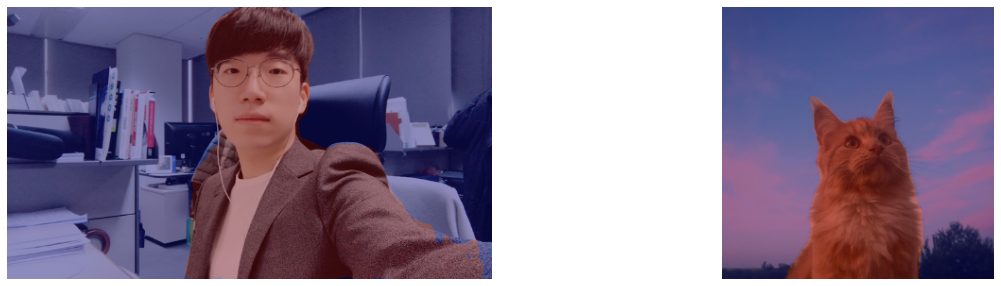

In [8]:
img_mask_human, img_show_human = get_segmetation_image(img_human_re, seg_map_human, 15)
img_mask_cat, img_show_cat = get_segmetation_image(img_cat_re, seg_map_cat, 8)


figure, axes = plt.subplots(1, 2)
figure.set_size_inches(20, 5)
for ax in axes:
    ax.axis('off')

axes[0].imshow(cv2.cvtColor(img_show_human, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크를 원본 사이즈에 맞게 출력해보자.

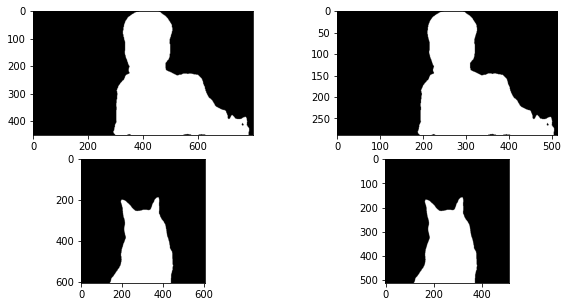

In [9]:
img_mask_human_re = cv2.resize(img_mask_human, img_human.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_human_re = cv2.threshold(img_mask_human_re, 128, 255, cv2.THRESH_BINARY)
img_mask_cat_re = cv2.resize(img_mask_cat, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_cat_re = cv2.threshold(img_mask_cat_re, 128, 255, cv2.THRESH_BINARY)


figure, axes = plt.subplots(2,2)
figure.set_size_inches(10, 5)

axes[0][0].imshow(img_mask_human_re, cmap=plt.cm.binary_r)
axes[0][1].imshow(img_mask_human, cmap=plt.cm.binary_r)

axes[1][0].imshow(img_mask_cat_re, cmap=plt.cm.binary_r)
axes[1][1].imshow(img_mask_cat, cmap=plt.cm.binary_r)
plt.show()

## 4. Blur 이미지

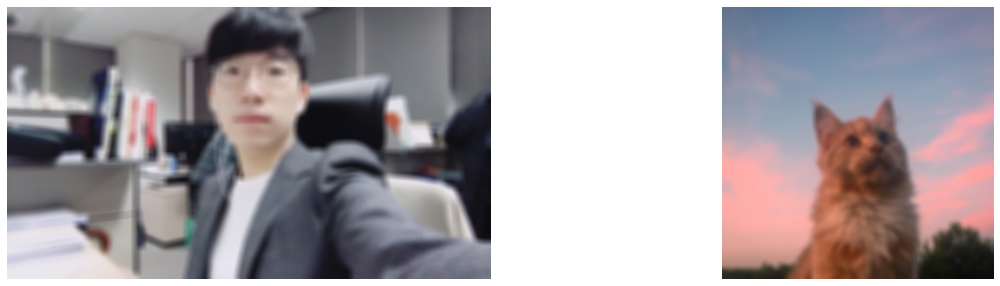

In [10]:
img_human_blur = cv2.blur(img_human, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
img_cat_blur = cv2.blur(img_cat, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(20, 5)
for ax in axes:
    ax.axis('off')

axes[0].imshow(cv2.cvtColor(img_human_blur, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(img_cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크를 이용해서 배경만 추출

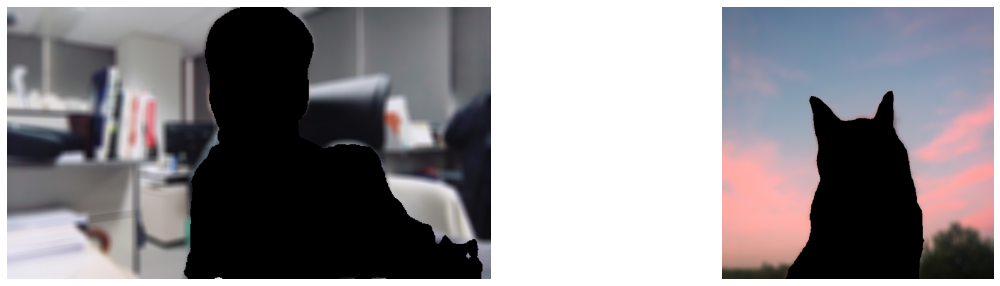

In [11]:
img_mask_color_human = cv2.cvtColor(img_mask_human_re, cv2.COLOR_GRAY2BGR)
img_bg_mask_human = cv2.bitwise_not(img_mask_color_human)
img_bg_blur_human = cv2.bitwise_and(img_human_blur, img_bg_mask_human)

img_mask_color_cat = cv2.cvtColor(img_mask_cat_re, cv2.COLOR_GRAY2BGR)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_blur_cat = cv2.bitwise_and(img_cat_blur, img_bg_mask_cat)

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(20, 5)
for ax in axes:
    ax.axis('off')

axes[0].imshow(cv2.cvtColor(img_bg_blur_human, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

## 5. Blur 배경과 원본 이미지를 합성

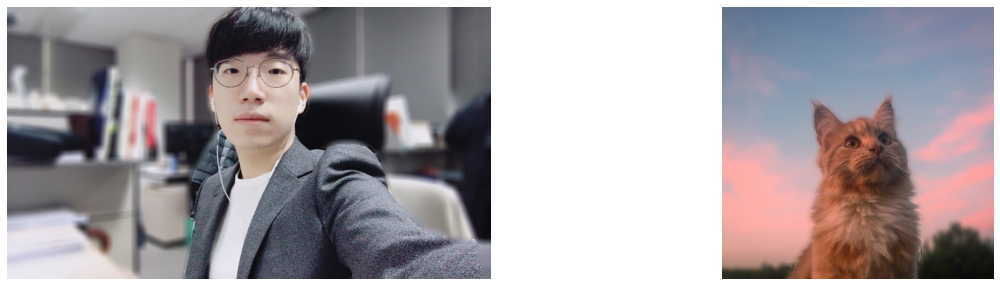

In [12]:
img_concat_human = np.where(img_mask_color_human==255, img_human, img_bg_blur_human)
img_concat_cat = np.where(img_mask_color_cat==255, img_cat, img_bg_blur_cat)

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(20, 5)
for ax in axes:
    ax.axis('off')

axes[0].imshow(cv2.cvtColor(img_concat_human, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

## 6. 배경 변경

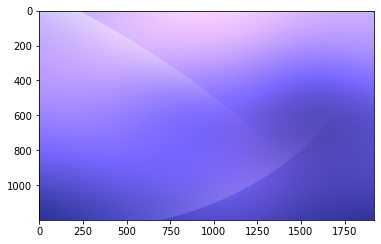

In [13]:
img_background = cv2.imread(img_path+'background.jpg')
fig = plt.figure() 
plt.imshow(cv2.cvtColor(img_background, cv2.COLOR_BGR2RGB))
plt.show()

위와 마찬가지로 배경을 이미지에 맞게 리사이즈한 후 합치자.

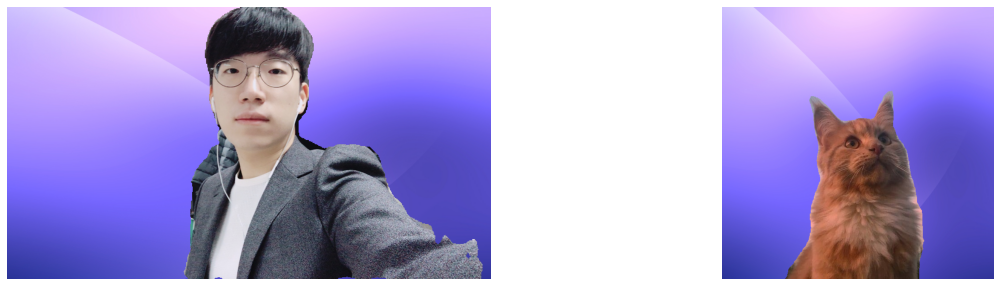

In [14]:
img_background_human = cv2.resize(img_background, (img_human.shape[1], img_human.shape[0]))
img_background_cat = cv2.resize(img_background, (img_cat.shape[1], img_cat.shape[0]))

img_background_human = cv2.bitwise_and(img_background_human, img_bg_mask_human)
img_background_cat = cv2.bitwise_and(img_background_cat, img_bg_mask_cat)

img_concat_human = np.where(img_mask_color_human==255, img_human, img_background_human)
img_concat_cat = np.where(img_mask_color_cat==255, img_cat, img_background_cat)

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(20, 5)
for ax in axes:
    ax.axis('off')

axes[0].imshow(cv2.cvtColor(img_concat_human, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.savefig('fig.png')
plt.show()

## 7. 문제점

현재 보이는 가장 큰 문제들은 세그멘테이션 이미지가 잘리거나,  
배경이 포함되는 문제가 있다.

단일 이미지에서 깊이 맵을 추출하여보자.  
monodepth2 라이브러리를 사용하였고, 출처는 다음과 같다.  
https://github.com/nianticlabs/monodepth2

### 네트워크 설정 및 가중치 로드

In [15]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval()

DepthDecoder(
  (decoder): ModuleList(
    (0): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (2): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (3): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (4): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv

### 테스트 이미지 로드 및 전처리

In [17]:
input_image = pil.open(img_path+'E-14-3.png').convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

### PyTorch 모델을 사용한 예측

In [18]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### 이미지에 대한 깊이 예측

(-0.5, 799.5, 449.5, -0.5)

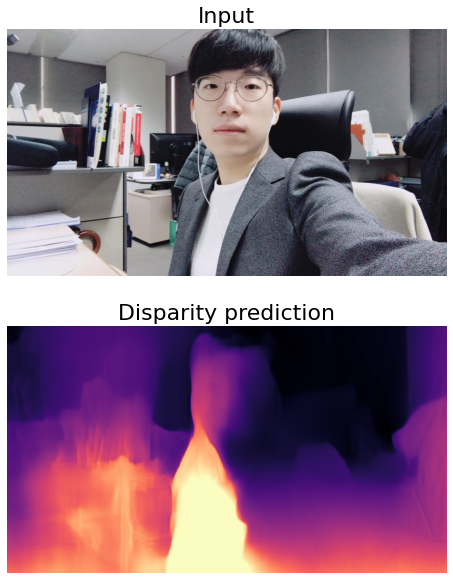

In [22]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off')

깊이 맵의 결과가 좋지 않았다.

원래 계획은 깊이 기반으로 추출한 이미지에서 다시 segmentation을 하는 것이였는데 결과가 좋지 않아 
바로 시도하지 못했다.